### Content

### 1.  Mounting the google drive to google colab

In [1]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [2]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
#from keras.optimizers import RMSprop, adam

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used fro RNN

In [3]:
# cd to pull my txt file from my google drive into google colab
%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep letters
data = re.sub("[^a-zA-Z]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

/content/gdrive/My Drive/Capstone/Data


### 4. Exploring text dataset

In [4]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  27


In [5]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [6]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

### 5. Numerical encode the sentences and features

In [7]:
len(data)

1208984

In [8]:
text = data

In [9]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402962


In [10]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming  attentive save the ', 't auditing this course helped me a lot in learning this language programming  attentive save the mon', 'uditing this course helped me a lot in learning this language programming  attentive save the money ', 'ting this course helped me a lot in learning this language programming  attentive save the money i w', 'g this course helped me a lot in learning this language programming  attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [ ]:
len(text)

1208984

In [11]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 6. define the model topolgy
 https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

In [13]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [14]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               79872     
_________________________________________________________________
dense (Dense)                (None, 27)                3483      
_________________________________________________________________
activation (Activation)      (None, 27)                0         
Total params: 83,355
Trainable params: 83,355
Non-trainable params: 0
_________________________________________________________________


### 7. Creating my ModelCheckpoint and callback requirements

In [15]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

In [16]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [17]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [18]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [19]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr]

### 8.Training my RNN model

In [20]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=100, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/100
2362/2362 [==============================] - 55s 10ms/step - loss: 2.3680 - accuracy: 0.3142 - val_loss: 1.6078 - val_accuracy: 0.5364

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " is just starting to learn programming   i am very much impressed with dr chuck as his method of tea"
 is just starting to learn programming   i am very much impressed with dr chuck as his method of teat on the course                                                                                                                                                                                                                                                                                                                                                                                                 
----- diversity: 0.5
----- Generating with seed: " is just starting to learn programming   i am very much impressed with dr chuck as his method of tea"
 is just s

In [ ]:
# when epoch increases 

### 9. evaluating performance of model

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [22]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 31s - loss: 0.7540 - accuracy: 0.7676


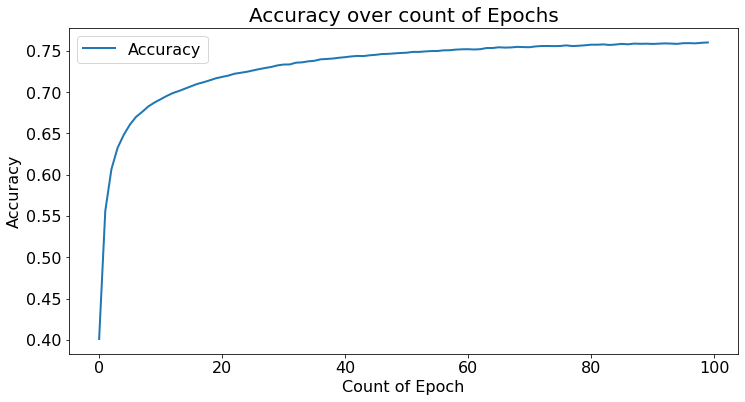

In [35]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


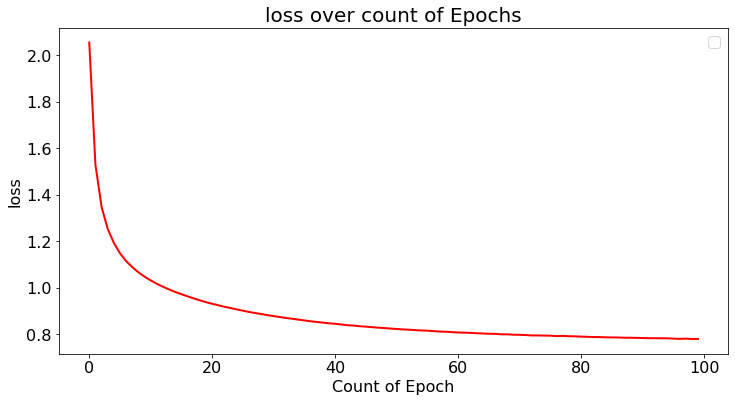

In [34]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

In [25]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 11s - loss: 1.0838 - accuracy: 0.6976


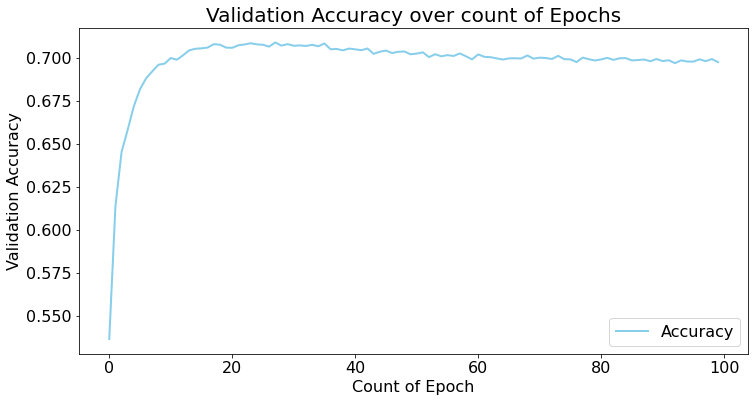

In [33]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=2, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

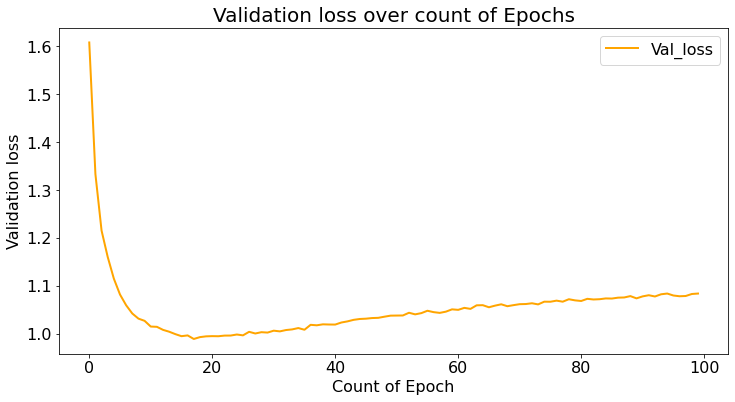

In [32]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=2, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

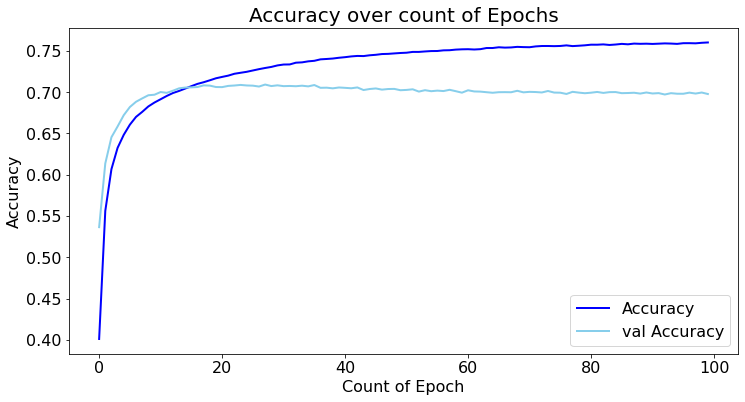

In [31]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=2, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


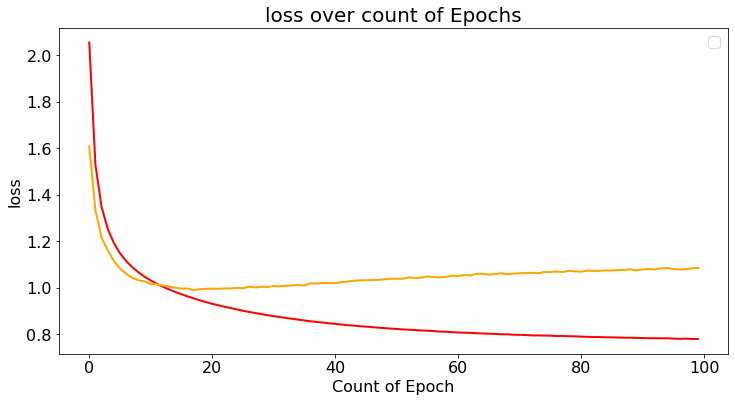

In [30]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 10. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 11.Try generating text using help from keras.io

In [ ]:
### Functions obtained from keras.io to help te
### to help predict the

IndentationError: ignored

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [36]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [37]:
print(generate_text(500, 0.2))

enough that this was a very high quality and well designed course  the online lectures are very good  i was able to complete the course is very good are a beginner  i was able to complete the course is very good and i was already absolutely nothing about the course is very easy to learn about python  i am so for all                                                                                                                                                                                                                                                                                           


In [38]:
print(generate_text(500, 0.5))

es a flavor of all the important topics required to start python   the bonus videos were also interesting  it is very easy to complete the course and i liked the nowe different sense  i didn t have any experience working of teaching and it s also interesting  dr  charles severance                                                                                                                                                                                                                                                                                                                               


In [39]:
print(generate_text(500, 1))

ing intro to programming and python   dr  chuck does a good job of not overwhelming in the first course  i completed the way topis is the bounduse continue comparisd  the videos are gle to the course i will taught it explains the assignment but i will make you are much me the video time i didn t too lecturer charles syseres crasses if you want to start class back  but it along a kind and help to dr charles severance pased and fun to follow the basic modute can clearly underbstand of topic and clear  i was all thank you   to the university of matice and exceptional topiching  i wanted now i wan


In [40]:
print(generate_text(1000, 0.2))

  it is a good start   el instructor es muy claro y hace las clases amenas  las explicaciones son explanation i have never help you the best course                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [41]:
print(generate_text(1000, 0.5))

elpful  i am planning to finish everything in this   course specialization  and this first course designed experience  i follow the course                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [42]:
print(generate_text(1000, 1))

i was brand new to python  the prof did a nice job breaking the material down enough that i could follow thries  i think it s plannte with new precisions  i used pace  but tiok minds on python difficult book who have not interested to learn python and they case remenct to fear in how he can  excellent course for thre work  it is a great clars are lackus to startnd with many sure that you get it easy to fixisher very didection   i am able to know this specialization   i am some like the teacher is the best caree    it is the best perfections of the lagges with a try about programming      also seriller them well as frustle teaches in extrome  might be a specialization and platforms like at fover  i love the profreming fundamental tops are starting abottinlic gained in more confulter learned i fanting to topal be helpful to be dingo foundation or suggestex in an easy to understand  the way then took  this course is didect from the referente lechur i have especial time alreared fun like c

In [43]:
print(generate_text(2000, 1))

ow nothing about programming this is a nice course to start with  very nice for beginners and dr  chuck was a great course and it isselt with moter amazing with plamerating the way he has been doing the bangago in the classres way if technoled i wit this class  it days  the course was a very spearer  thanks for the prefection of python with python   the course is great for this of programming as a to briloing developing  i also like this course   this opportunity  thank you charles  this course syntax  the lecturer  white lectures in the most important  thank you very much  useful way to be very dayed concepts was nece programming with excellencises on some clarical ant and coursera    excellent course uses uight  which was must books free  he start to c e just python  little classes   great introductory seems like and otherwise per us  many some user took the course important first times like an able to follow that i have done m accurate the teachers part of the introduction und impre

In [44]:
generated1 = generate_text(1000, 1)

In [45]:
from textblob import TextBlob

In [46]:
b = TextBlob(generated1)
b.correct()

TextBlob("ly  the way professor chuck delivered the concept of patron from scratch helped me to do coming and high becoming specialist professor  this course passion canst spacefullicate video are so   i recommend it to programming with patron  learning studying to the end  giving a smile or truly  this was an awesome  if you re completely was a very table  the basic stall start  i may tone concise     it s a very good study  the course charles is easy to take other plastic in any  i would recommend it to access this introductory course   and also a man and get break for begranees without a material in this    and at all  beside the teachers are such a allowneve begun you sayntand especial this course amazing only courses i am convertible  i will series of labor  not through the specifically the video  it has reaches and this is right  and i was already learned high  it was a please knowledjems to enrollitanes that complete course tools with learning of patron  learned prince  so face 

In [47]:
generated2 = generate_text(2000, 1)

b2 = TextBlob(generated2)
b2.correct()

TextBlob("his course so much am willing to take all the course taught by dr chuck    so far i ve enjoyed it   the video sections material is example    love you all a bully about the many former like the treatment the video conversical from to program and understanding their gives definition of patron   loved classever s become by dr charles severance  i have previously easy to understand   i also like s interitime and is this structures that was a background to this  best teaching to get into patron with patron  the related to the text part     this cutting no faced for me  as personally to teach meaning of programming course i m very clear  mr chuck i well reactive able to follow the course which made it encouragement you don t give sure to only truly from the were  i was animation environmental  that s great class sincefilicily  for help so you can learn from background in as easy  so even for a beginner language also at all your begin made me beginners with it will step to patron a

In [ ]:
from autocorrect import Speller
check = Speller(lang='en')
check(generated1)

ModuleNotFoundError: ignored